In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 21 15:04:54 2021

Code for decision variables
"""

import numpy as np
import matplotlib.pyplot as plt



In [107]:
class Accumulator():
    def __init__(self, src, tar, rng, x = 0, v0 = 0.01, w = 1, wd = 1, ws = 1):
        self.source = src
        self.target = tar
        self.x = x
        self.x_acc = []
        self.w = w
        self.wd = wd
        self.ws = ws
        self.threshold = 0.2
        self.dt = 0.01
        self.v0 = v0
        self.reached = False
        self.rng = rng

        
    def run(self, Q, Q_P, ne, useNE=False):
        
        q1 = Q[self.source]
        q2 = Q[self.target]
        if useNE :
            dx = (self.v0 + (1- ne) *Q_P[self.source] + (1- 1.5*ne) * self.wd * (q1 - q2) +  (1+ 1.5*ne) * self.ws * (q1 + q2)) * self.dt +  self.rng.normal(loc=0.0, scale=0.01)
        else:
            dx = (self.v0 + Q_P[self.source] + self.wd * (q1 - q2) + self.ws * (q1 + q2)) * self.dt +  self.rng.normal(loc=0.0, scale=0.01)
        self.x = self.x + dx
        self.x_acc.append(self.x)
        if self.x >= self.threshold:
            self.reached = True
        return self.x

def WinAll(accs) :
    for src in accs:
        src_reached = accs[src]["reached"]
        for othr_src in accs:
            if othr_src == src: continue
            if src_reached == 2 and accs[othr_src]["reached"] < 2 :
                return {"decision": src, "random": False}
    #print("Returning random")
    return {"decision" : np.random.randint(3), "random": True}

def TaskProcess(decision, contingencies):
    prob_status = np.random.uniform()
#    if decision == 0:
    if prob_status <= contingencies[decision]:
        reward = 1
    else:
        reward = 0
    return reward

def updateQvals(Q, reward, alpha, decision, ne):
    ### Involve NE in learning
    Q[decision] = Q[decision] +  (1 + 2*ne) * alpha * (reward - Q[decision])
    return Q

def updateQvalsStoch(Q, reward, alpha, decision, lOFCCredAssign, prevChoice, prevRew):
    chance = np.random.uniform()
    wrongAssigned = False
    if chance <= lOFCCredAssign: # Assign current reward to current choice
        pass
    elif chance <= lOFCCredAssign + (1-lOFCCredAssign)/2: # Assign current reward to previous choice
        decision = prevChoice if (prevChoice != -1) else decision
        wrongAssigned = True
    else : # Assign previous reward to current choice
        reward = prevRew if (prevRew != -1) else reward
        wrongAssigned = True
    Q[decision] = Q[decision] +  alpha * (reward - Q[decision])
    return Q, wrongAssigned

def updateQ_Pvals(Q_P, reward, alpha_P, decision, ne):
    ### Involve NE in learning
    Q_P[decision] = Q_P[decision] + (1 + ne) * (alpha_P * reward * Q_P[decision])
    return Q_P

def plotDecisions(combinations, accs, trial):
    fig, axs = plt.subplots(len(combinations), 1, figsize=(10,4))
    fig.suptitle("Trial %s"%trial)
    for i in range(len(combinations)) :
        combi = combinations[i]
        ax = axs[i]
        xlen = np.max([len(accs[combi[0]]["others"][combi[1]].x_acc), len(accs[combi[1]]["others"][combi[0]].x_acc)])
        ax.plot(accs[combi[0]]["others"][combi[1]].x_acc, '--b', label=str(combi[0])+'_'+str(combi[1]))[0]
        ax.plot(accs[combi[1]]["others"][combi[0]].x_acc, '--r', label=str(combi[1])+'_'+str(combi[0]))[0]
        ax.plot(0.2 + np.zeros(xlen), '--g')
        ax.plot(-0.2 + np.zeros(xlen), '--g')
        ax.legend(loc='upper right')



In [108]:
task_dur = 2.5 # time in seconds
ds = 0.01 # sampling time
time_steps = np.linspace(0, int(task_dur/ds - 1), int(task_dur/ds))
num_sessions = 250
total_trials = 150
combinations = [[0, 1], [0, 2], [1, 2]]
opts = np.array([0, 1, 2])

medialExpName = "medial-lesion-SCA-perfs"
lateralExpName = "lateral-lesion-SCA-perfs"
ctrl_prefix = "ctrl-SCA-"

contingencies_labels = [
    "V2_HIGH", "V2_MEDIUM", 
    "V2_LOW"]
def runSession(parameters, session, contingencies, rng, alpha = 0.01, alpha_P=0.01, ws=1, reversal=False) :
    trials = 0
    Q_init = np.zeros(3) + parameters["Q_init"]
    Q_curr = Q_init
    Q_P_curr = Q_init
    performance = []
    req_trials = -1
    long_term_reward_trials = 30
    short_term_reward_trials = 3
    long_term_mean_reward = 0
    short_term_mean_reward = 0
    NE_s, NE_l = 0,0
    tau = .01
    ne_efficiency = 0.8
    reversed = False
    NE_session_data = []
    Q1_session_data = []
    Q3_session_data = []
    randomDecisions = 0
    prevChoice = -1
    prevRew = -1
    numWrongAssigned = 0
    while trials < total_trials:
        if reversal == True and not reversed and trials == total_trials//2 :
            contingencies = np.flip(contingencies)
            reversed = True
        best_choice = np.argmax(contingencies)
        accs = {}
        for opt in opts:
            accs[opt] = {"others": {}, "reached": 0}
            for i in opts[opts != opt]:
                accs[opt]["others"][i] = Accumulator(opt, i, rng, v0=parameters["V0"], wd=parameters["W_D"], ws=parameters["W_S"]) 
        for t in time_steps:
            NE_s = NE_s + tau * (-NE_s + short_term_mean_reward - long_term_mean_reward)
            NE_l = NE_l + tau * (-NE_l + long_term_mean_reward - short_term_mean_reward)
            NE_release = np.abs(NE_s)+np.abs(NE_l)
            NE = np.max([0.5, 1 - ne_efficiency * NE_release])
            for src in accs:
                for tar in accs[src]["others"] :
                    acc = accs[src]["others"][tar]
                    if not acc.reached : 
                        acc.run(Q_curr, Q_P_curr, NE_release)
                        if acc.reached :
                            accs[src]["reached"] += 1
        NE_session_data.append(NE_release)
        result = WinAll(accs)
        decision = result["decision"]
        if(result["random"]) :
            randomDecisions += 1
        if decision == best_choice : performance.append(1)
        else : performance.append(0)
        long_term_mean_reward = np.mean(performance[-1*long_term_reward_trials:])
        short_term_mean_reward = np.mean(performance[-1*short_term_reward_trials:])
        #print('Decision :: ', decision)
        reward = TaskProcess(decision, contingencies)
        #print('Trial %d : decision : %d' % (trials, decision) )
        #Q_curr = updateQvals(Q_curr, reward, parameters["alpha"], decision, 0) #NE_release)
        Q_curr, wrongAssigned = updateQvalsStoch(Q_curr, reward, parameters["alpha"], decision, parameters["lOFCCredAssign"], prevChoice, prevRew)
        if wrongAssigned :
            numWrongAssigned += 1
        Q1_session_data.append(Q_curr[0])
        Q3_session_data.append(Q_curr[2])
        Q_P_curr = updateQ_Pvals(Q_P_curr, reward, parameters["alpha_PV"], decision, 0) #NE_release)
#        if(trials == 0 or trials == 10):
#            plotDecisions(combinations, accs, trials)
        trials += 1
        prevChoice = decision
        prevRew = reward
        if len(performance) > 10 and np.mean(performance[-5:]) > .7 and req_trials == -1 :
            req_trials = trials
    if req_trials == -1 : req_trials = trials
    return {"perf": np.array(performance), "trials": req_trials, "NE" : NE_session_data, "Q1": Q1_session_data, "Q3": Q3_session_data, "random" : randomDecisions}
    




In [109]:
contingencies = [
    [0.6, 0.4, 0.01],
    [0.6, 0.2, 0.01],
    [0.6, 0.02, 0.01]
]

In [110]:
def runControl(parameters, expName, rng) :
    c_perfs = []
    c_req_trials = []
    for c in contingencies :
        print("for scenario : ", c)
        sessionPerfs = []
        ses_req_trials = []
        for i in range(num_sessions) :
            sd = runSession(parameters["ctrl"], i, c, rng)
            ses_req_trials.append(sd["trials"])
            sessionPerfs.append(sd["perf"])
        c_req_trials.append(np.array(ses_req_trials).mean())
        c_perfs.append(np.array(sessionPerfs))

    np.save(ctrl_prefix+expName+".npy", {"perfs" : c_perfs, "trials" : c_req_trials}, allow_pickle=True)
    print("======= DONE CTRL for " + expName + "========")


In [111]:
def runMedialLesion(parameters, runCTRL=True) :
    rng = np.random.default_rng(1)
    if runCTRL :
        runControl(parameters, medialExpName, rng)
    c_perfs = []
    c_req_trials = []
    for c in contingencies :
        print("for scenario : ", c)
        sessionPerfs = []
        ses_req_trials = []
        for i in range(num_sessions) :
            sd = runSession(parameters["medial-lesion"], i, c, rng, ws=0)
            ses_req_trials.append(sd["trials"])
            sessionPerfs.append(sd["perf"])
        c_req_trials.append(np.array(ses_req_trials).mean())
        c_perfs.append(np.array(sessionPerfs))

    np.save(medialExpName+".npy", {"perfs" : c_perfs, "trials" : c_req_trials}, allow_pickle=True)
    print("======= DONE MEDIAL LESION ========")


In [112]:
def runLateralLesion(parameters, ws=1.2, alpha_P=0.001, runCTRL=True) :
    rng = np.random.default_rng(2)
    if runCTRL :
        runControl(parameters, lateralExpName, rng)
    c_perfs = []
    c_req_trials = []
    for c in contingencies :
        print("for scenario : ", c)
        sessionPerfs = []
        ses_req_trials = []
        for i in range(num_sessions) :
            sd = runSession(parameters["lateral-lesion"], i, c, rng, ws=ws, alpha_P=alpha_P)
            ses_req_trials.append(sd["trials"])
            sessionPerfs.append(sd["perf"])
        c_req_trials.append(np.array(ses_req_trials).mean())
        c_perfs.append(np.array(sessionPerfs))

    np.save(lateralExpName+".npy", {"perfs" : c_perfs, "trials" : c_req_trials}, allow_pickle=True)

    print("======= DONE LATERAL LESION ========")


In [113]:
def runReversal() :
    rng = np.random.default_rng(2)
    c_perfs = []
    c_req_trials = []
    NE_release = []
    Q1 = []
    Q3 = []
    for c in contingencies :
        sessionPerfs = []
        ses_req_trials = []
        ses_ne_release = []
        ses_Q1 = []
        ses_Q3 = []
        randomPerSession = []
        for i in range(num_sessions) :
            sd = runSession(i, c, rng, reversal=True)
            ses_req_trials.append(sd["trials"])
            sessionPerfs.append(sd["perf"])
            ses_ne_release.append(sd["NE"])
            ses_Q1.append(sd["Q1"])
            ses_Q3.append(sd["Q3"])
            randomPerSession.append(sd["random"])
        print("%s : Avg random decisions : %d" % (c, np.mean(randomPerSession)))
        c_req_trials.append(np.array(ses_req_trials).mean())
        c_perfs.append(np.array(sessionPerfs))
        NE_release.append(np.array(ses_ne_release))
        Q1.append(np.array(ses_Q1))
        Q3.append(np.array(ses_Q3))

    np.save("reversal-perfs-low.npy", {"perfs" : c_perfs, "trials" : c_req_trials, "NE": NE_release, "Q1": Q1, "Q3": Q3}, allow_pickle=True)

    print("======= DONE REVERSAL ========")
    

In [114]:
v0 = 0.01
wd = 1
ws = 1 * 0.3
alpha = 0.01
alpha_P = 0.01
medial_lesion_multiplier = (1/3)
lateral_lesion_multiplier = (1/3) # 2/5, 1/2, 
parameters = {
    "ctrl" :     {"Q_init" : 0, "V0": v0, "W_D" : wd, "W_S" : ws,"alpha" : alpha, "lOFCCredAssign" : .8, "alpha_PV": alpha_P},
    "lateral-lesion" :     {"Q_init" : 0, "V0": v0, "W_D" : wd, "W_S" : ws,"alpha" : alpha*lateral_lesion_multiplier, "lOFCCredAssign" : .6, "alpha_PV": alpha_P*lateral_lesion_multiplier},
    "medial-lesion" :     {"Q_init" : 0, "V0": v0, "W_D" : wd, "W_S" : ws * medial_lesion_multiplier,"alpha" : alpha, "lOFCCredAssign" : .8, "alpha_PV": alpha_P},
}

In [115]:
#runReversal()
runLateralLesion(parameters, runCTRL=True) ### also address credit assignment
runMedialLesion(parameters, runCTRL=True)


for scenario :  [0.6, 0.4, 0.01]
for scenario :  [0.6, 0.2, 0.01]
for scenario :  [0.6, 0.02, 0.01]
======= DONE CTRL for lateral-lesion-SCA-perfs========
for scenario :  [0.6, 0.4, 0.01]
for scenario :  [0.6, 0.2, 0.01]
for scenario :  [0.6, 0.02, 0.01]
======= DONE LATERAL LESION ========
for scenario :  [0.6, 0.4, 0.01]
for scenario :  [0.6, 0.2, 0.01]
for scenario :  [0.6, 0.02, 0.01]
======= DONE CTRL for medial-lesion-SCA-perfs========
for scenario :  [0.6, 0.4, 0.01]
for scenario :  [0.6, 0.2, 0.01]
for scenario :  [0.6, 0.02, 0.01]
======= DONE MEDIAL LESION ========


In [116]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition)
def plotSessions(c_perfs, trials_per_session, colors, contingencies_labels, title):
    fig, axs = plt.subplots(1, len(contingencies_labels), figsize=(20,8))
    fig.suptitle("Performance by difficulty : " + title)
    width = 0.3 
    labels = ['Control', title]
    for i in range(len(contingencies_labels)) :
        ax = axs[i]
        ax_inset = inset_axes(ax, width="30%", height="20%", loc=4, borderpad=1)
        ax_inset.tick_params(labelbottom=False)
        ax_inset.set_ylim(0, trials_per_session)
        for idx, c_perf in enumerate(c_perfs) :
            sessionsPerfData = c_perf.get("perfs")[i]
            c_req_trials = c_perf.get("trials")[i]
            X = np.arange(np.shape(sessionsPerfData)[1])
            mean = sessionsPerfData.mean(axis=0)
            var = sessionsPerfData.var(axis=0)
            position = np.argmax(mean >= .8)
            ax.plot(X, mean, '--'+colors[idx], label=labels[idx])[0]
            ax.plot(X, mean + var, c=colors[idx], lw=.5)
            ax.plot(X, mean - var, c=colors[idx], lw=.5)
            ax.set_title(contingencies_labels[i])
            ax.vlines(position, 0, 1, color=colors[idx])
            ax.fill_between(X, mean + var, mean - var, color=colors[idx], alpha=.1)
            ax.legend(loc='center right')
            ax_inset.bar(idx*width , c_req_trials,  width, color=colors[idx])

def plotV1ProportionByPeriod(perfs, contingencies_labels, titles, colors, trials_per_session, num_periods=3):
    fig, ax = plt.subplots(1, 1, figsize=(10,4))
    fig.suptitle("No. of trials for 70% performance in 10 consecutive trials : ")
    ind = np.arange(len(contingencies_labels))
    width = 0.3
    for idx, perf in enumerate(perfs) : 
#        perf_by_period = np.reshape(perf, (perf.))
        for i in range(len(titles)) :
            ax.bar((ind - width/len(contingencies_labels)) + i*width , c_req_trials[i],  width, color=colors[i], label = titles[i])
    ax.set_ylim(0, trials_per_session)
    ax.set_xticks(ind)
    ax.set_xticklabels(contingencies_labels)
    ax.legend(loc='upper right')
            

def plotRequiredTrials(c_req_trials, contingencies_labels, titles, colors, trials_per_session):
    fig, ax = plt.subplots(1, 1, figsize=(10,4))
    fig.suptitle("No. of trials for 70% performance in 10 consecutive trials : ")
    ind = np.arange(len(contingencies_labels))
    width = 0.3       
    for i in range(len(titles)) :
        ax.bar((ind - width/len(contingencies_labels)) + i*width , c_req_trials[i],  width, color=colors[i], label = titles[i])
    ax.set_ylim(0, trials_per_session)
    ax.set_xticks(ind)
    ax.set_xticklabels(contingencies_labels)
    ax.legend(loc='upper right')


def plot(Data_2d, title):
    fig, ax = plt.subplots(1, 1, figsize=(10,4))
    fig.suptitle("Data : " + title)
    X = np.arange(np.shape(Data_2d)[1])
    mean = Data_2d.mean(axis=0)
    var = Data_2d.var(axis=0)
    position = np.argmax(mean >= .8)
    ax.plot(X, mean, '--b')[0]
    ax.plot(X, mean + var, c='r', lw=.5)
    ax.plot(X, mean - var, c='r', lw=.5)
    ax.fill_between(X, mean + var, mean - var, color='r', alpha=.1)


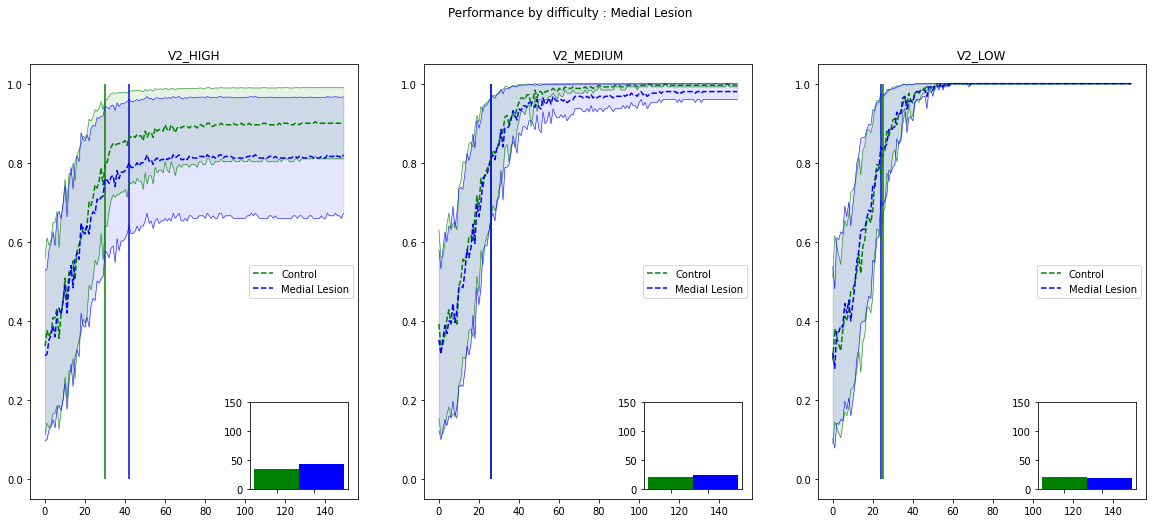

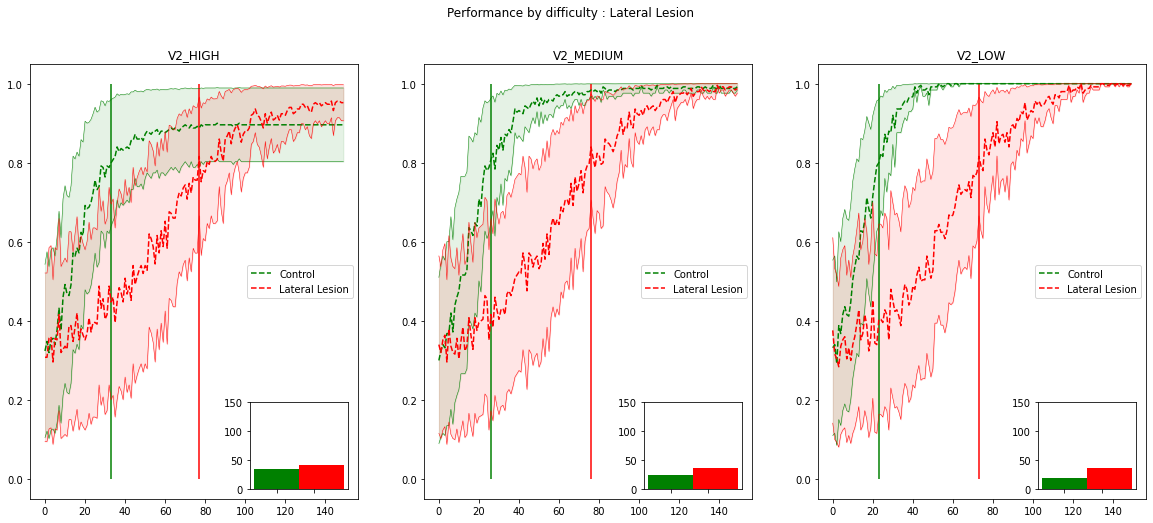

In [ ]:
data_folder = '' #'npy-alpha-lat-lesion-4x/'
medial = np.load(data_folder+"medial-lesion-SCA-perfs.npy",allow_pickle=True);
ctrl_medial = np.load(data_folder+"ctrl-SCA-medial-lesion-SCA-perfs.npy",allow_pickle=True);
lateral = np.load(data_folder+"lateral-lesion-SCA-perfs.npy",allow_pickle=True);
ctrl_lateral = np.load(data_folder+"ctrl-SCA-lateral-lesion-SCA-perfs.npy",allow_pickle=True);
#reversal = np.load("reversal-perfs-low.npy",allow_pickle=True);
plotSessions([ctrl_medial.item(), medial.item()], total_trials, ['g', 'b'], contingencies_labels, 'Medial Lesion')
plotSessions([ctrl_lateral.item(), lateral.item()], total_trials, ['g', 'r'],contingencies_labels, 'Lateral Lesion')
#plotSessions([reversal.item().get("perfs")], contingencies_labels, 'Reversal')
#plot(reversal.item().get("NE")[0], "NE Release")
#plot(reversal.item().get("Q1")[0], "Q1")
#plot(reversal.item().get("Q3")[0], "Q3")
#plotRequiredTrials([ctrl_medial.item().get("trials"),medial.item().get("trials"), ctrl_lateral.item().get("trials"), lateral.item().get("trials")], 
#                   contingencies_labels, ['Control', 'Medial Lesion', 'Control', 'Lateral Lesion'], ['g', 'b', 'g', 'r'], total_trials)
#plotRequiredTrials([medial.item().get("trials")], 
                   #contingencies_labels, ['Medial Lesion'], total_trials)
    

 - Session performances - decisions
 - Observe reaction times, learning rate, reward magnitude, V0
 - Task contingencies - easy, mid, difficult
 - W_s = 0, V2_HIGH BAD Performance
 - 
 Noise, threshold, learning rate
 Add controls to each with same random seed
 Reaction times.
 Why high variance?
 

In [120]:
periods = 3
period_labels = []
for period in np.arange(periods) :
    period_labels.append(str(period+1) + "/" + str(periods))
v1_proportions = {"ctrl" : {}, "medial" : {}}
for idx, scenario in enumerate(ctrl_medial.item().get("perfs")):
    sessions, trials = np.shape(scenario)
    normalized = np.reshape(scenario, (sessions, trials//periods, periods))
    v1_proportions["ctrl"][contingencies_labels[idx]] = {"mean" : np.mean(np.mean(normalized, axis=1), axis=0), "var" : np.var(np.mean(normalized, axis=1), axis=0)}
for idx, scenario in enumerate(medial.item().get("perfs")):
    sessions, trials = np.shape(scenario)
    normalized = np.reshape(scenario, (sessions, trials//periods, periods))
    v1_proportions["medial"][contingencies_labels[idx]] = {"mean" : np.mean(np.mean(normalized, axis=1), axis=0), "var" : np.var(np.mean(normalized, axis=1), axis=0)}
v1_proportions

{'ctrl': {'V2_HIGH': {'mean': array([0.85136, 0.85896, 0.85944]),
   'var': array([0.01166295, 0.01139572, 0.01130689])},
  'V2_MEDIUM': {'mean': array([0.86912, 0.8696 , 0.87128]),
   'var': array([0.00707203, 0.00708544, 0.00645036])},
  'V2_LOW': {'mean': array([0.89088, 0.89864, 0.89936]),
   'var': array([0.00391683, 0.00343335, 0.00397079])}},
 'medial': {'V2_HIGH': {'mean': array([0.69512, 0.69488, 0.7036 ]),
   'var': array([0.08097299, 0.08088579, 0.08366864])},
  'V2_MEDIUM': {'mean': array([0.8124 , 0.8136 , 0.82192]),
   'var': array([0.01493584, 0.01556224, 0.01507471])},
  'V2_LOW': {'mean': array([0.8488 , 0.8504 , 0.85296]),
   'var': array([0.00555456, 0.00518784, 0.00500324])}}}

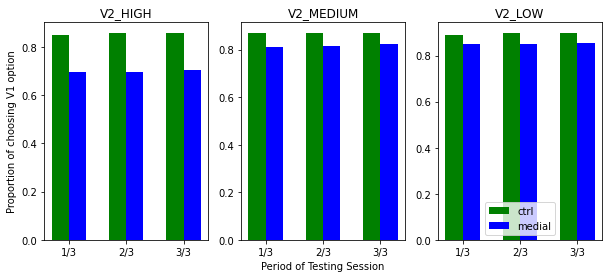

In [108]:
width = 0.3
conditions = ["ctrl", "medial"]
num_conditions = len(conditions)
colors = ['g', 'b']
fig, axs = plt.subplots(1, len(contingencies_labels), figsize=(10,4))
xticks = np.arange(periods)
for label_idx, label in enumerate(contingencies_labels) :
    ax = axs[label_idx]
    ax.set_xticks(xticks)
    ax.set_xticklabels(period_labels)
    ax.set_title(label)
#    if True:
    for cond_idx, condition in enumerate(conditions) :
        ax.bar(xticks-((num_conditions-1)*width/2)+cond_idx*width, v1_proportions[condition][label]["mean"],  width, color=colors[cond_idx], label=condition)
    if label_idx == 0:
        ax.set_ylabel('Proportion of choosing V1 option')
    elif label_idx == len(contingencies_labels) // 2:
        ax.set_xlabel('Period of Testing Session')
plt.legend()
### Combine scenarios